In [28]:
#!pip install pillow


In [36]:
from PIL import Image, ImageOps
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [38]:
def max_sizes(input_folder,limit_width=None):
    max_width = 0
    max_height = 0
    # First, iterate through all images to find the maximum dimensions
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                if width > max_width:
                    max_width = width
                if height > max_height:
                    max_height = height
    if limit_width != None:
        max_height = int(round(max_height*limit_width/max_width,0))
        max_width = limit_width
    return max_width, max_height


# Define the range of white color
def is_white_color(color, threshold=230):
    # Check if color is close to white within the given threshold
    return all(c >= threshold for c in color)


# Adjust threshold based on what is considered "close to white"
def crop_white_bottom_from_image(img, height_to_check=8, check_width=10, start_from=60, threshold=230):
    width, height = img.size
    # Define the region to check for white color
    box = (start_from, height - height_to_check, start_from + check_width, height)
    region = img.crop(box)
    # Convert the region to a NumPy array for easy processing
    region_np = np.array(region)
    # Check if all pixels in the region are close to white
    white_pixels = np.apply_along_axis(is_white_color, 1, region_np)
    
    if np.all(white_pixels):
        # Crop the bottom 16 pixels
        img = img.crop((0, 0, width, height - height_to_check - 8))
    return img


def padding_images(img,max_width,max_height):
    # Calculate padding required to center the image
    delta_width = max_width - img.width
    delta_height = max_height - img.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    # Add padding and create a new image with the desired size
    return ImageOps.expand(img, padding, fill=0)

def format_to_rgb(img):
    if img.mode != 'RGB':
        # Convert image to RGB
        img = img.convert('RGB')
    return img

def reducing_width(img, max_width=640):
    #Get the image dimensions
    width, height = img.size
    # If the image width is greater than 640, resize it
    if width > max_width:
        # Calculate the scaling factor
        scale_factor = max_width / width
        new_width = max_width
        new_height = int(height * scale_factor)
        # Resize the image
        img = img.resize((new_width, new_height), Image.LANCZOS)
    return img



'def augment_images(input_folder, target_num_images):\n    # Create a generator for data augmentation\n    datagen = ImageDataGenerator(\n        rotation_range=40,       # Rotations\n        width_shift_range=0.2,   # Width shifts\n        height_shift_range=0.2,  # Height shifts\n        shear_range=0.2,         # Shear angle shifts\n        zoom_range=0.2,          # Zooming\n        horizontal_flip=True,    # Horizontal flipping\n        fill_mode=\'nearest\'      # Filling new pixels after transformation\n    )\n    # Get a list of all files in the folder\n    images = [f for f in os.listdir(input_folder) if f.endswith((\'.png\', \'.jpg\', \'.jpeg\'))]\n    # Count the number of original images\n    original_num_images = len(images)\n    # Calculate how many times to loop through each image to reach target_num_images\n    num_copies_per_image = target_num_images // original_num_images\n    extra_images = target_num_images % original_num_images\n    image_count = 0\n    # Augmentat

In [44]:
# Augmentation for birds and hogs

def augment_class_images(input_folder, label_csv, target_classes):
    # Load the CSV file with labels
    df = pd.read_csv(label_csv)
    # Calculate the average number of images across all classes
    class_counts = df.drop(columns=['id']+target_classes).sum(axis=0)
    avg_count = int(class_counts.mean())
    # Create a generator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,       # Rotations
        width_shift_range=0.2,   # Width shifts
        height_shift_range=0.2,  # Height shifts
        shear_range=0.2,         # Shear angle shifts
        zoom_range=0.2,          # Zooming
        horizontal_flip=True,    # Horizontal flipping
        fill_mode='nearest'      # Filling new pixels after transformation
    )
    # Perform augmentation for each target class
    for target_class in target_classes:
        # Filter the dataframe for the target class
        class_df = df[df[target_class] == 1]
        # Calculate how many images need to be generated
        num_images_needed = avg_count - len(class_df)

        print(target_class, num_images_needed)

        # Create output folder for the augmented images
        output_folder = os.path.join(input_folder, f'{target_class}_augmented')
        os.makedirs(output_folder, exist_ok=True)
        image_count = 0
        for _, row in class_df.iterrows():
            img_path = os.path.join(input_folder, row['id']+'.jpg')
            img = load_img(img_path)
            x = img_to_array(img)  # Convert image to numpy array
            x = x.reshape((1,) + x.shape)  # Add dimension to work with ImageDataGenerator
            # Generate new images
            for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix=target_class, save_format='jpeg'):
                image_count += 1
                if image_count >= num_images_needed:
                    break
        print(f"Created {num_images_needed} augmented images for class '{target_class}' in folder '{output_folder}'.")

# Specify the input folder where images are stored and the CSV file path
input_folder = '../data/new_train_features'
label_csv = '../data/train_labels.csv'
# Specify the classes that need augmentation
target_classes = ['bird', 'hog']
augment_class_images(input_folder, label_csv, target_classes)


bird 670
Created 2310 augmented images for class 'bird' in folder '../data/new_train_features/bird_augmented'.
hog 1333
Created 2310 augmented images for class 'hog' in folder '../data/new_train_features/hog_augmented'.


In [32]:
def crop_white_bottom_add_padding_all_rgb(input_folder,output_folder):
    limit_width = 640 # None if we want to have maximal width 960
    max_width, max_height = max_sizes(input_folder,limit_width)

    # Create the new folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through each image in the source folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                img = crop_white_bottom_from_image(img)
                img =  reducing_width(img,limit_width)
                img = padding_images(img,max_width,max_height)
                img = format_to_rgb(img)
                # Save the original image to the new folder
                new_file_path = os.path.join(output_folder, filename)
                img.save(new_file_path)
    print(output_folder, "Processing complete.")

In [33]:
# Path to the train folder and the new train folder
input_train_folder = '../data/train_features'
output_train_folder = '../data/new_train_features'

# Path to the test folder and the new test folder
input_test_folder = '../data/test_features'
output_test_folder = '../data/new_test_features'


crop_white_bottom_add_padding_all_rgb(input_train_folder,output_train_folder)
crop_white_bottom_add_padding_all_rgb(input_test_folder,output_test_folder)

../data/new_train_features Processing complete.
../data/new_test_features Processing complete.


Found 13190 validated image filenames.
Found 3298 validated image filenames.


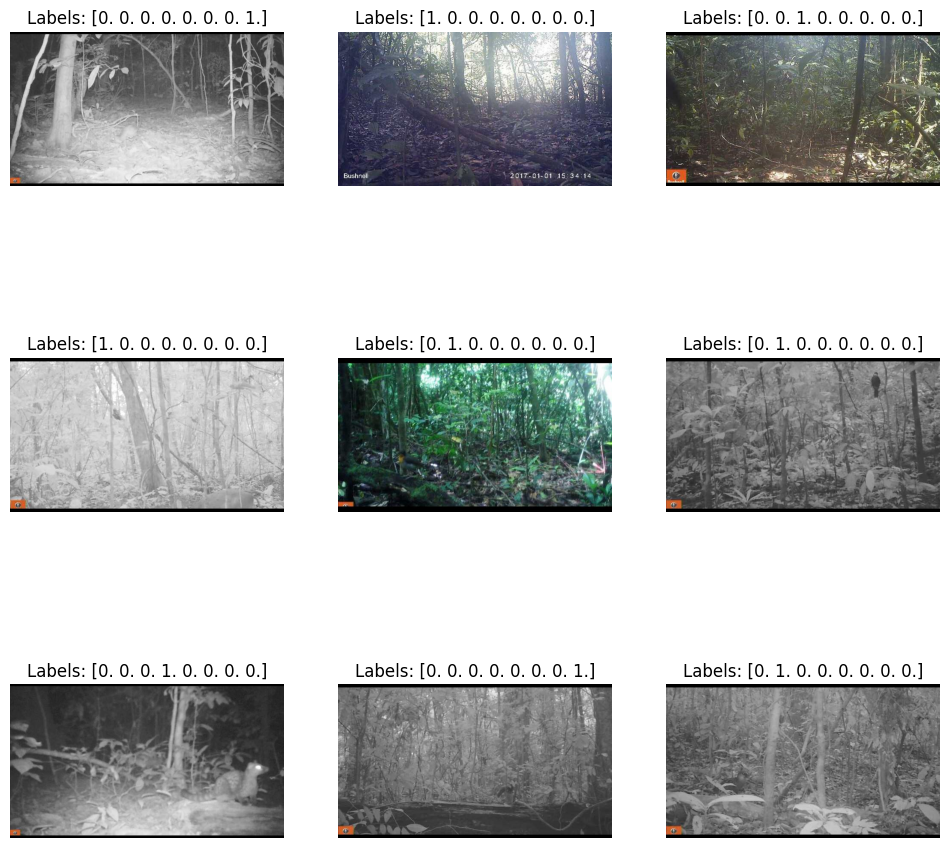

In [34]:
# Paths
dataset_folder = '../data/new_train_features'  # Path to the folder with images
labels_file = '../data/train_labels.csv'  # Path to the CSV file with labels
# Image parameters
img_width, img_height = max_sizes(dataset_folder)
#img_height = 128  # Set your image height
#img_width = 128   # Set your image width
batch_size = 32

# Load labels from CSV
df = pd.read_csv(labels_file)

frac = 1.0

df = df.sample(frac=frac, random_state=1)


# Add a full path to each image in the dataframe
df['id'] = df['id'].apply(lambda x: os.path.join(dataset_folder, x+'.jpg'))

# Perform stratified split based on the labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[df.columns[1:]])

# Data generator
datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
# Create the training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='id',
    y_col=train_df.columns[1:],  # All columns except 'ID' are labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)
# Create the validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='id',
    y_col=val_df.columns[1:],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)



# Example: Display a batch of images and labels
images, labels = next(train_generator)  # Get a batch of images and labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Labels: {labels[i]}")
    plt.axis('off')
plt.show()

In [35]:
"""model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(len(df.columns) - 1, activation='softmax')  # Output layer for multi-label classification
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)"""

"model = Sequential([\n    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),\n    MaxPooling2D(pool_size=(2, 2)),\n    Conv2D(16, (3, 3), activation='relu'),\n    MaxPooling2D(pool_size=(2, 2)),\n    Flatten(),\n    Dense(16, activation='relu'),\n    Dense(len(df.columns) - 1, activation='softmax')  # Output layer for multi-label classification\n])\nmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])\n# Train the model\nmodel.fit(train_generator, validation_data=val_generator, epochs=10)"

In [ ]:
"""model.save('../models/firstCNNmodel')"""

In [ ]:
# Load the saved model
with tf.device('/cpu:0'):
    new_model = tf.keras.models.load_model('../models/firstCNNmodel')

# Check its architecture
new_model.summary()